In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [3]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor

In [4]:
df = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
# df.head()

In [ ]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
df_test.head()

In [ ]:
df.info()

In [ ]:
df.describe().round(1)

In [ ]:
df.isna().sum()

In [ ]:
sns.heatmap(df.isna().sort_values(by=["Occupation"]) == True)

In [5]:
# df.dropna(inplace = True)
for non_object_column in df.select_dtypes(exclude = "object").columns:
    df[non_object_column].fillna(df[non_object_column].mean(), inplace = True)

df.dropna(inplace = True)

In [6]:
df.shape

(775274, 21)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df.select_dtypes(exclude = "object").corr(), annot = True, cmap = "Reds")

In [ ]:
df_categorical = df.select_dtypes('object')
for object_column in df_categorical.columns:
    print(object_column, {df[object_column].nunique()}, ': ', df[object_column].unique(), '\n')

In [7]:
df.drop(['id', 'Policy Start Date'], axis = 1, inplace = True)

In [ ]:
for non_object_column in df.select_dtypes(exclude = "object").columns:
    if non_object_column != 'Premium Amount':
        df[non_object_column] = df[non_object_column] / df[non_object_column].max()

In [ ]:
df.head()

In [ ]:
df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"].apply(lambda x: x[:10]))

In [ ]:
pd.get_dummies(df_categorical, drop_first = True, dtype = int)

In [8]:
df = pd.concat(
    [
        df.select_dtypes(exclude = "object"), 
        pd.get_dummies(df.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)
df.head()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_Male,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,19.0,10049.0,1.0,22.598761,2.0,17.0,372.00000,5.0,2869.0,0,...,0,1,0,1,0,0,0,1,0,1
2,23.0,25602.0,3.0,47.177549,1.0,14.0,592.92435,3.0,567.0,1,...,0,1,1,0,1,0,0,1,0,1
4,21.0,39651.0,1.0,20.376094,0.0,8.0,598.00000,4.0,2022.0,1,...,0,1,0,1,1,0,0,1,0,1
7,48.0,127237.0,2.0,5.769783,1.0,11.0,398.00000,5.0,111.0,0,...,1,0,0,0,0,0,1,0,1,0
9,44.0,52447.0,2.0,20.473718,1.0,9.0,635.00000,3.0,64.0,1,...,1,0,0,1,0,0,0,0,1,0


In [9]:
df.to_csv("train_new.csv", index=False)

In [5]:
df = pd.read_csv("/kaggle/working/train_new.csv")

In [9]:
df.dtypes

Age                            float64
Annual Income                  float64
Number of Dependents           float64
Health Score                   float64
Previous Claims                float64
Vehicle Age                    float64
Credit Score                   float64
Insurance Duration             float64
Premium Amount                 float64
Gender_Male                      int64
Marital Status_Married           int64
Marital Status_Single            int64
Education Level_High School      int64
Education Level_Master's         int64
Education Level_PhD              int64
Occupation_Self-Employed         int64
Occupation_Unemployed            int64
Location_Suburban                int64
Location_Urban                   int64
Policy Type_Comprehensive        int64
Policy Type_Premium              int64
Customer Feedback_Good           int64
Customer Feedback_Poor           int64
Smoking Status_Yes               int64
Exercise Frequency_Monthly       int64
Exercise Frequency_Rarely

In [11]:
df.describe()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_Male,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
count,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,...,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000
mean,41.148867,32294.908373,2.008073,25.611307,1.001807,9.580240,591.494932,5.019517,1098.686541,0.502064,...,0.333367,0.334941,0.327967,0.334271,0.501668,0.249401,0.249103,0.255400,0.332827,0.333280
std,13.431284,31135.470133,1.350615,11.822272,0.819426,5.774261,141.496247,2.595893,865.133053,0.499996,...,0.471417,0.471970,0.469473,0.471735,0.499998,0.432667,0.432494,0.436086,0.471225,0.471386
min,18.000000,2.000000,0.000000,2.024415,0.000000,0.000000,300.000000,1.000000,20.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,8791.000000,1.000000,16.551470,0.000000,5.000000,481.000000,3.000000,511.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.145563,24881.000000,2.000000,25.613908,1.000000,10.000000,592.924350,5.000000,867.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,53.000000,43787.000000,3.000000,33.754214,1.002689,15.000000,705.000000,7.000000,1502.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,64.000000,149997.000000,4.000000,58.975914,8.000000,19.000000,849.000000,9.000000,4997.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
x = df.drop(['Premium Amount'], axis = 1)
y = df['Premium Amount']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [13]:
model1 = LinearRegression()
model2 = RandomForestRegressor(n_estimators=28, random_state=0)
model3 = PolynomialFeatures(degree=4)
model4 = CatBoostRegressor(
#                             iterations=1000,
                            learning_rate=0.01,
                            depth = 9,
                            n_estimators = 1000
)

In [ ]:
x_train = model3.fit_transform(x_train)
x_test = model3.fit_transform(x_test)
x = model3.fit_transform(x)

In [14]:
# model = model3
# model.fit(model3.fit_transform(x_train))

# model = model1
# model.fit(model3.fit(model3.fit_transform(x_train)), y_train)

model = model4
model.fit(x_train, y_train)

0:	learn: 863.9849631	total: 139ms	remaining: 2m 19s
1:	learn: 863.6124398	total: 220ms	remaining: 1m 49s
2:	learn: 863.2878339	total: 285ms	remaining: 1m 34s
3:	learn: 862.9201355	total: 351ms	remaining: 1m 27s
4:	learn: 862.5644237	total: 417ms	remaining: 1m 23s
5:	learn: 862.2400989	total: 485ms	remaining: 1m 20s
6:	learn: 861.9007665	total: 554ms	remaining: 1m 18s
7:	learn: 861.5600654	total: 619ms	remaining: 1m 16s
8:	learn: 861.2643668	total: 686ms	remaining: 1m 15s
9:	learn: 860.9570150	total: 750ms	remaining: 1m 14s
10:	learn: 860.6393706	total: 817ms	remaining: 1m 13s
11:	learn: 860.3374105	total: 885ms	remaining: 1m 12s
12:	learn: 860.0253669	total: 951ms	remaining: 1m 12s
13:	learn: 859.7264557	total: 1.01s	remaining: 1m 11s
14:	learn: 859.4870706	total: 1.08s	remaining: 1m 10s
15:	learn: 859.1872718	total: 1.15s	remaining: 1m 10s
16:	learn: 858.9101734	total: 1.21s	remaining: 1m 10s
17:	learn: 858.6317023	total: 1.28s	remaining: 1m 9s
18:	learn: 858.3731047	total: 1.34s	rem

In [15]:
y_pred = model.predict(x_test)

In [16]:
def rmsle(predictions, targets):
    """Calculate the root mean squared logarithmic error between predictions and targets"""
    return np.sqrt(np.mean((np.log(predictions + 1) - np.log(targets + 1)) ** 2))

In [20]:
df_pred = pd.DataFrame([y_pred, y_test]).transpose()
df_pred = df_pred.describe()
df_pred['diff'] = df_pred[0] - df_pred[1]
df_pred['0/1'] = df_pred[0] / df_pred[1]
df_pred

,0,1,diff,0/1
count,155055.000000,155055.000000,0.000000,1.000000
mean,1098.277812,1099.595872,-1.318060,0.998801
std,176.789678,868.249656,-691.459978,0.203616
min,363.938721,20.000000,343.938721,18.196936
25%,1054.943058,509.000000,545.943058,2.072580
50%,1089.258485,861.000000,228.258485,1.265109
75%,1147.265024,1504.000000,-356.734976,0.762809
max,1766.978318,4988.000000,-3221.021682,0.354246


<ipython-input-48-57f1de8a0ccb>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


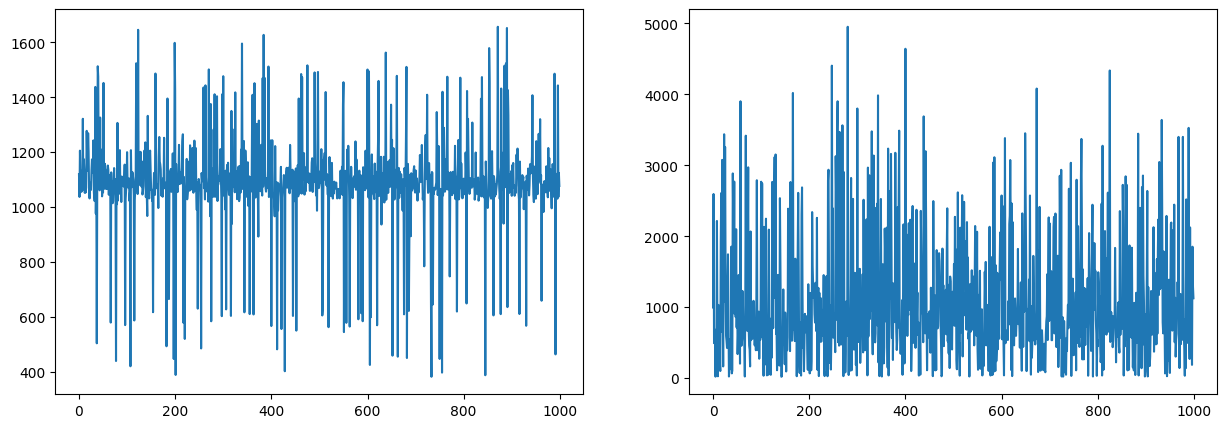

In [48]:
fig, ax = plt.subplots(figsize=(15, 5), sharey=True)
plt.subplot(1, 2, 1)
plt.plot(df_pred[0][:1000])
plt.subplot(1, 2, 2)
plt.plot(df_pred[1][:1000])

In [21]:
rmsle(y_pred, y_test)

1.140090163725516

In [47]:
rmsle(y_pred-325, y_test)

1.0674467810277197

In [48]:
model.fit(x, y)

0:	learn: 864.7892142	total: 134ms	remaining: 2m 13s
1:	learn: 864.4325969	total: 217ms	remaining: 1m 48s
2:	learn: 864.0836579	total: 296ms	remaining: 1m 38s
3:	learn: 863.7211923	total: 376ms	remaining: 1m 33s
4:	learn: 863.3747844	total: 456ms	remaining: 1m 30s
5:	learn: 863.0318477	total: 538ms	remaining: 1m 29s
6:	learn: 862.6957448	total: 618ms	remaining: 1m 27s
7:	learn: 862.3548994	total: 701ms	remaining: 1m 26s
8:	learn: 862.0335645	total: 779ms	remaining: 1m 25s
9:	learn: 861.7241891	total: 862ms	remaining: 1m 25s
10:	learn: 861.4130214	total: 941ms	remaining: 1m 24s
11:	learn: 861.1124264	total: 1.02s	remaining: 1m 23s
12:	learn: 860.8074147	total: 1.1s	remaining: 1m 23s
13:	learn: 860.5161157	total: 1.18s	remaining: 1m 23s
14:	learn: 860.2823346	total: 1.25s	remaining: 1m 22s
15:	learn: 859.9927105	total: 1.33s	remaining: 1m 22s
16:	learn: 859.7179543	total: 1.41s	remaining: 1m 21s
17:	learn: 859.4463964	total: 1.49s	remaining: 1m 21s
18:	learn: 859.1840483	total: 1.57s	rem

In [19]:
x.shape

(775274, 28)

In [49]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")

# for non_object_column in df_test.select_dtypes(exclude = "object").columns:
#     df_test[non_object_column] = df_test[non_object_column] / df_test[non_object_column].max()

for non_object_column in df_test.select_dtypes(exclude = "object").columns:
    df_test[non_object_column].fillna(df_test[non_object_column].mean(), inplace = True)

df_test["Policy Start Date"] = pd.to_datetime(df_test["Policy Start Date"].apply(lambda x: x[:10]))

df_test = pd.concat(
    [
        df_test.select_dtypes(exclude = "object"), 
        pd.get_dummies(df_test.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)

x_df_test = df_test.drop(['id', 'Policy Start Date'], axis = 1)

print(x_df_test.shape)
x_df_test.head()

(800000, 28)


,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Gender_Male,Marital Status_Married,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,28.0,2310.0,4.0,7.657981,1.004873,19.0,592.904749,1.0,0,0,...,0,0,0,1,1,0,0,1,0,1
1,31.0,126031.0,2.0,13.381379,1.004873,14.0,372.000000,8.0,0,1,...,0,1,1,0,1,0,1,0,0,0
2,47.0,17092.0,0.0,24.354527,1.004873,16.0,819.000000,9.0,0,0,...,1,0,0,0,1,1,0,0,1,0
3,28.0,30424.0,3.0,5.136225,1.000000,3.0,770.000000,5.0,0,0,...,1,0,0,1,1,0,0,0,0,1
4,24.0,10863.0,2.0,11.844155,1.004873,14.0,755.000000,7.0,1,0,...,0,1,0,0,0,0,0,1,0,1


In [50]:
Y_pred_test = model.predict(x_df_test)

In [51]:
df_sub = pd.read_csv("/kaggle/input/playground-series-s4e12/sample_submission.csv")
df_sub.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


In [52]:
Y_pred_test = Y_pred_test - 330

In [53]:
df_test['Premium Amount'] = Y_pred_test.round(3)
df_submission = df_test[['id', 'Premium Amount']]

print(df_submission.shape)
df_submission.head()

(800000, 2)


,id,Premium Amount
0,1200000,1172.850
1,1200001,792.085
2,1200002,709.005
3,1200003,759.441
4,1200004,699.543


In [54]:
df_submission.to_csv("submissions.csv", index=False)

In [ ]:
df_test.isna().sum()